# Monitoring with alibi_detect

If needed install:

In [96]:
!which python3
!pip install matplotlib

/usr/local/bin/python3


In [97]:
!pip install ipython

In [98]:
!pip install seaborn~=0.13.2

## Introduction

Illustrating the need to monitor metrics at various window sizes to catch performance degradation as soon as possible.

Imagine we are logging/saving the F1 metrics every day fo 35 days. To mimic this, we will output random numbers in predefined intervals for every hour of the 35 days.

- For the first 20 days we will use the interval [94, 98)
- For the next 5 days we will use the interval [92, 96)
- For the next 5 days we will use the interval [88, 96)
- For the last 5 days we will use the interval [86, 92)

Please note how the interval for random generating changes, this is how we mimic a drift in the data.

In [99]:
pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [100]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))


In [101]:
hourly_f1 = np.array(hourly_f1)


##### **TODO:** Compute the **cumulative mean** of the F1 values given in `hourly_f1`.

For example for an array `[3, 1, 2, 10]` a cumulative mean array would be: `[3, 2, 2, 4]`.

Explanation:
- at iteration 0: we use the element at 0th position in original array to calculate the mean --> 3/1=3
- at iteration 1: we use the elements at 0th and 1st position in original array to calculate the mean --> (3+1)/2=2
- at iteration 2: we use the elements at 0th, 1st and 2nd position in original array to calculate the mean --> (3+1+2)/3=2
- at iteration 3: we use the elements at 0th and up to 3rd position in original array to calculate the mean --> (3+1+2+10)/4=4

In [102]:
c_means =[]
for i in range(0, len(hourly_f1)):
    c_mean = np.mean(hourly_f1[:i+1])
    c_means.append(c_mean)
c_means = np.array(c_means)
# print(c_means)


##### **TODO:** Print the average cumulative F1 on the last day.

In [103]:
avg_f1 = np.mean(c_means[-24:])
print(avg_f1)

93.72678105927541


##### **TODO:** Calculate the **daily sliding F1** of the values given in `hourly_f1`.

For example for an array [ 4,  2,  3,  8, -6, 10] a sliding average with a window of size 3 would be: [3, 4.33, 1.667, 4].

Explanation:

- at iteration 0: we use the first 3 elements to calculate the mean --> (4+2+3)/3=3
- at iteration 1: we use the elements at 1st,2nd,3rd position in original array to calculate the mean --> (2+3+8)/3=4.333
- at iteration 2: we use the elements at 2nd,3rd,4th position in original array to calculate the mean --> (3+8-6)/3=1.667
- at iteration 3: we use the elements at 3rd,4th,5th position in original array to calculate the mean --> (8-6+10)/3=4

In [104]:
sliding_avg = []
window_size = 24
for i in range(len(hourly_f1) - window_size + 1):
    window = hourly_f1[i:i + window_size]
    window_avg = np.mean(window)
    sliding_avg.append(window_avg)
sliding_avg = np.array(sliding_avg)
# print(sliding_avg)

##### **TODO:** Print the average sliding F1 on the last day.

In [105]:
mean_sliding_avg = np.mean(sliding_avg[-24:])
print(mean_sliding_avg)

88.06597222222221


##### **TODO:** Plot the cumulative and sliding values on a graph.

- Y-axes can be limited to `[80,100]`.

- Optionally, add a threshold line at `y=90`

Text(0.5, 1.0, 'Hourly F1 Score Monitoring')

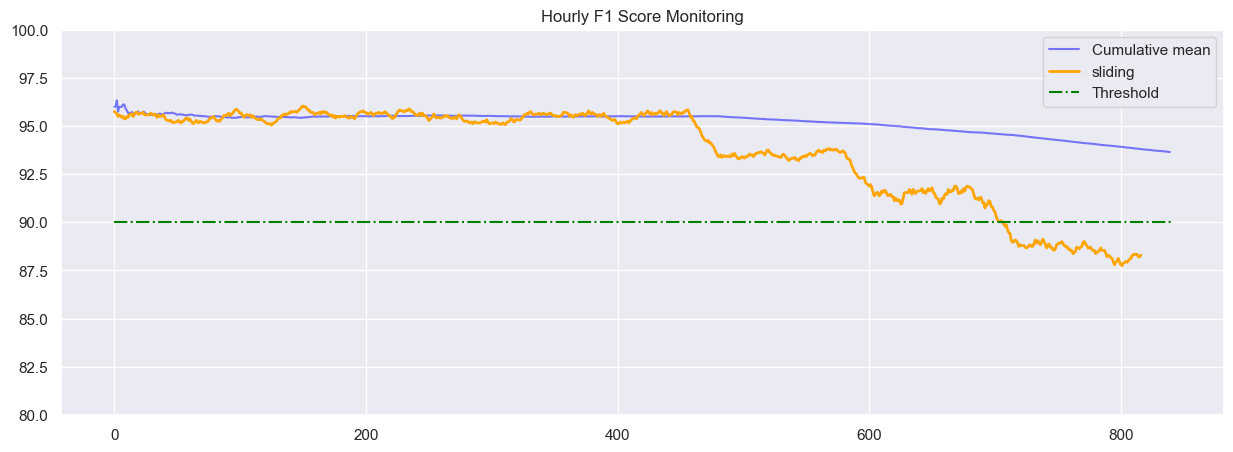

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(c_means, label='Cumulative mean', color='blue', alpha=0.5)
plt.plot(sliding_avg, label='sliding', color='orange', linewidth=2)
plt.ylim(80, 100)
plt.hlines(y = 90, xmin=0, xmax=len(hourly_f1), colors="green", linestyles= "dashdot", label='Threshold')
plt.legend()
plt.title('Hourly F1 Score Monitoring')

## Data

In [107]:
import json
import pandas as pd

##### **TODO:**
1. Read the `projects` and `tags` files and join them into a `combined` dataframe.
2. Create a new column called `text` where you will place the `title` and `description` joined with a space character -- `{title} {description}`.
3. Drop the `title` and `description` columns.

In [108]:
# 1. Read the files
projects = pd.read_csv("projects.csv")
tags = pd.read_csv("tags.csv")

# Join on a common key (adjust "project_id" to whatever column they share)
combined = pd.merge(projects,tags)

# 2. Create the new column "text"
combined["text"] = combined["title"] + " " + combined["description"]

# 3. Drop the original columns
combined = combined.drop(columns=["title", "description"])

# Show result
print(combined.head())


   id           created_on                     tag  \
0   6  2020-02-20 06:43:18         computer-vision   
1   7  2020-02-20 06:47:21          graph-learning   
2   9  2020-02-24 16:24:45  reinforcement-learning   
3  15  2020-02-28 23:55:26          graph-learning   
4  25  2020-03-07 23:04:31          graph-learning   

                                                text  
0  Comparison between YOLO and RCNN on real world...  
1  Show, Infer & Tell: Contextual Inference for C...  
2  Awesome Graph Classification A collection of i...  
3  Awesome Monte Carlo Tree Search A curated list...  
4  AttentionWalk A PyTorch Implementation of "Wat...  


We will use this dataframe as our reference/original data, data that we used to train our ML models. Not to be mistaken with the "real-world" data received in prod

## Univariate

Drift detection on univariate data.


### Kolmogorov-Smirnov (KS) test

KS test for detecting data drift on input sequence length. We can even monitor aspects of our data that aren't necessarily inputs to the model (ex. length of input text).

In [109]:
!pip install alibi_detect --upgrade
!pip install pyOpenSSL==22.0.0

  Using cached alibi_detect-0.12.0-py3-none-any.whl.metadata (28 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pillow-10.4.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached scikit_image-0.22.0.tar.gz (22.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [10 lines of output]
      + meson setup /private/var/folders/c6/1npg_m3n3qz9mc8qxyh2_2600000gn/T/pip-install-m4vo8yzf/scikit-image_1e7f3e57050f4b01894132dbb8146ffa /private/var/

##### **TODO**:
1. Create a new column that will hold the number of words (e.g., separated by " ") in the `text` column
2. Plot a histogram for the first 200 rows of the newly created column from original dataframe

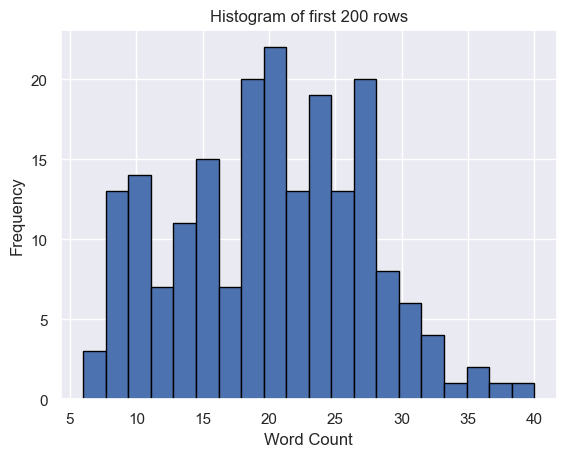

In [110]:
import matplotlib.pyplot as plt
# 1. Create column with word counts
combined["word_count"] = combined["text"].apply(lambda x: len(str(x).split()))

# 2. Take first 200 rows and plot histogram
subset = combined.head(200)

plt.hist(subset["word_count"], bins=20, edgecolor="black")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Histogram of first 200 rows")
plt.show()

##### **TODO:** Initialize the KSDrift detector on the reference data.

In [111]:

pip install alibi-detect


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [112]:
from alibi_detect.cd import KSDrift
import numpy as np

combined["num_words"] = combined.text.apply(lambda x: len(x.split(" ")))

# Generate reference data (e.g. 1000 samples, 10 features)
X_ref = combined["word_count"][0:200].to_numpy()  # Using word_count as a feature
# Initialize the KSDrift detector, p_val: significance level, usually 0.05 
length_drift_detector = KSDrift(X_ref, p_val=0.05)


##### **TODO:**
1. Plot a histogram for the first 200 rows from original dataframe (same as previous task).
2. On top of it, plot a histogram for the next 200 rows (i.e., `[200,400)`) from original dataframe

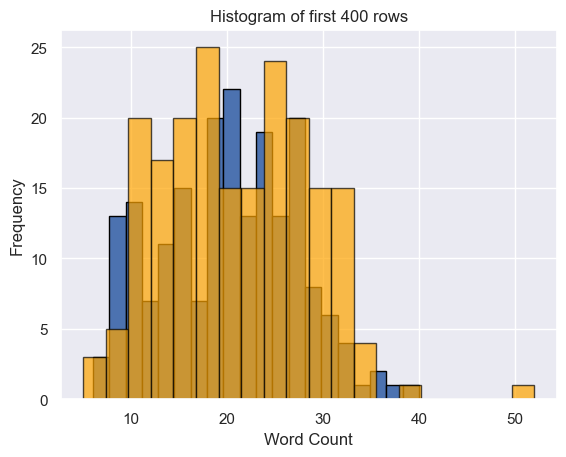

In [116]:
#1. Plot a histogram for the first 200 rows from original dataframe (same as previous task).
plt.hist(subset["word_count"], bins=20, edgecolor="black")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Histogram of first 200 rows")

#2. On top of it, plot a histogram for the next 200 rows (i.e., `[200,400)`) from original dataframe
No_drift = combined.iloc[200:400]
plt.hist(No_drift["word_count"], bins=20, edgecolor="black", alpha=0.7, color='orange')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Histogram of first 400 rows")
plt.show()

##### **TODO:** Apply the drift detector.

In [119]:
# Apply the drift detector
preds = length_drift_detector.predict(No_drift["word_count"].values.reshape(-1, 1))
print(preds)

{'data': {'is_drift': 0, 'distance': array([0.105], dtype=float32), 'p_val': array([0.20524779], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'KSDrift', 'online': False, 'data_type': None, 'version': '0.12.0', 'detector_type': 'drift'}}


Given that both dataframes are actually part of the same data, there is no noticeble drift to be detected.

##### **TODO:**
1. Create new data (to represent production data) from a normal distribution with mean=30 and std=5; you can create 200 examples.
2. Plot a hist of this data on top of the hist of the reference data (first 200 rows).

In [120]:
New_data = np.random.normal(30, 5, len(X_ref))

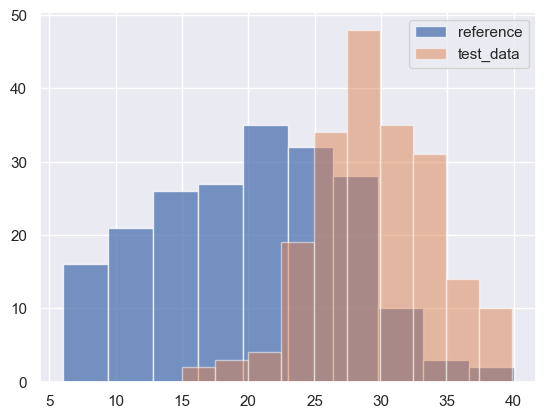

In [121]:
plt.hist(X_ref, alpha=0.75, label="reference")
plt.hist(New_data, alpha=0.5, label="test_data")
plt.legend()
plt.show()

##### **TODO:** Apply the drift detector to the reference data and the normal distributed (production) data.

In [128]:
length_drift_detector = KSDrift(New_data, p_val=0.05)
#print(length_drift_detector)
length_drift_detector = length_drift_detector.predict(combined["word_count"].values.reshape(-1, 1))
length_drift_detector

{'data': {'is_drift': 1,
  'distance': array([0.59159684], dtype=float32),
  'p_val': array([0.], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}

### Chi-squared test

Detecting drift on categorical variables (can be used for data or target drift).


In [129]:
from alibi_detect.cd import ChiSquareDrift
import numpy as np
combined["num_words"] = combined.text.apply(lambda x: len(x.split(" ")))


##### **TODO:**
1. Add a new column to the reference data called `token_count`. This column should have the value `small` if the `num_tokens` is less or equal than 10; `medium` if in between (10,25] and `large` if larger than 25.
2. Plot the first 200 data of reference data as a histogram.

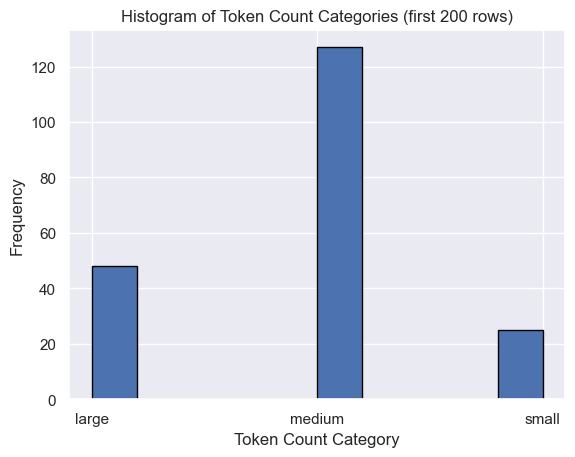

In [139]:
#1.Add a new column to the reference data called `token_count`. This column should have the value `small` if the `num_tokens` is less or equal than 10; `medium` if in between (10,25] and `large` if larger than 25.
def categorize_token_count(num_tokens):
    if num_tokens <= 10:
        return 'small'
    elif 10 < num_tokens <= 25:
        return 'medium'
    else:
        return 'large'
combined['token_count'] = combined['num_words'].apply(categorize_token_count)
#2. Plot the first 200 data of reference data as a histogram.
plt.hist(combined['token_count'][0:200], bins=10, edgecolor='black')
plt.xlabel("Token Count Category")
plt.ylabel("Frequency")
plt.title("Histogram of Token Count Categories (first 200 rows)")
plt.show()   

##### **TODO:** Initialize the drift detector

In [133]:
#2. Initialize the ChiSquareDrift detector using the `token_count` column as reference data.
X_ref = combined["token_count"][0:200].to_numpy().reshape(-1, 1)  # Using token_count as a feature
chi2_drift_detector = ChiSquareDrift(X_ref, p_val=0.05)

##### **TODO:**
1. Take the next 200 data rows from original data, and plot it over the reference data (first 200 rows).
2. Apply the drift detector.

In [140]:
No_drift = combined.iloc[200:400]
preds = chi2_drift_detector.predict(No_drift["token_count"].values.reshape(-1, 1))
print(preds)

{'data': {'is_drift': 1, 'distance': array([7.497912], dtype=float32), 'p_val': array([0.02354231], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'ChiSquareDrift', 'online': False, 'data_type': None, 'version': '0.12.0', 'detector_type': 'drift'}}


##### **TODO:**
1. Create production data, where you have 80 times `small`, 40 times `medium` and 80 times `large`.
2. Plot the histogram of productions data on top of reference data (first 200 rows).
3. Apply drift detector.

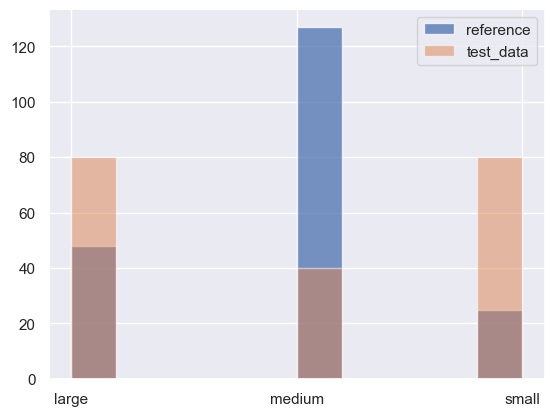

In [141]:
#1. Create production data, where you have 80 times `small`, 40 times `medium` and 80 times `large`.
New_data = np.array(['small']*80 + ['medium']*40 + ['large']*80).reshape(-1, 1)

#2. Plot the histogram of productions data on top of reference data (first 200 rows).
plt.hist(combined['token_count'][0:200], alpha=0.75, label="reference")
plt.hist(New_data, alpha=0.5, label="test_data")
plt.legend()
plt.show()

In [142]:
#3. Apply drift detector.
chi2_drift_detector = ChiSquareDrift(New_data, p_val=0.05)
chi2_drift_detector = chi2_drift_detector.predict(New_data)
chi2_drift_detector

{'data': {'is_drift': 0,
  'distance': array([0.], dtype=float32),
  'p_val': array([1.], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}